In [2]:
import numpy as np
import matplotlib,json,os
# matplotlib.use('Agg', force=True)
import matplotlib.pyplot as plt

# read results in ./profile_results/results/ and get average inference time

model_name='resnet50'
parallel=1
ee_head=0
results_files = os.listdir('./profile_results_resnet50/results/')

batch_sizes = [0]
inference_times = [0]
for f in results_files:
    name_parts = f.split('_')
    if name_parts[0] == model_name and name_parts[2] == str(parallel):
        pass
    else:
        continue
    with open(f'./profile_results_resnet50/results/{f}', 'r') as file:
        data = json.load(file)
        batch_sizes.append(data["meta"]["batch"])
        inference_times.append(data["summary"]["mean_ms"])
# sort by batch size
batch_sizes, inference_times = zip(*sorted(zip(batch_sizes, inference_times)))

# plot
plt.figure(figsize=(8,6))
plt.plot(batch_sizes[:-1], inference_times[:-1], marker='o', label='inference time')


# 只用前 10 个点做一次线性回归
x = np.asarray(batch_sizes[1:11], dtype=float)
y = np.asarray(inference_times[1:11], dtype=float)
coef = np.polyfit(x, y, 1)          # coef[0] 是斜率，coef[1] 是截距
fit_fn = np.poly1d(coef)

x_line = np.linspace(min(batch_sizes), max(batch_sizes[:-2]), 400)
plt.plot(x_line, fit_fn(x_line), color='r', linestyle='-', label='1st-order fit (first 10)')
plt.xlabel('Batch Size')
plt.ylabel('Average Inference Time (ms)')



plt.legend()
plt.title(f'Batch Size vs Average Inference Time for {model_name}, EE Head={ee_head}')
plt.grid(True)

plt.savefig(f'{model_name}_inference_time_vs_batch_size.png')
plt.show()


In [8]:
import os,json
import numpy as np
import matplotlib,json,os
# matplotlib.use('Agg', force=True)
import matplotlib.pyplot as plt
model_name='resnet50ee'
parallel=1
results_files = os.listdir('./profile_results/results/')

batch_size_set = set()
ee_head_set = set()
for f in results_files:
    name_parts = f[:-5].split('_')
    if name_parts[0] == model_name and name_parts[2] == str(parallel):
        pass
    else:
        continue
    batch_size_set.add(int(name_parts[4]))
    ee_head_set.add(int(name_parts[6]))
print(f'Found batch sizes: {sorted(batch_size_set)}')
print(f'Found EE heads: {sorted(ee_head_set)}')

ee_head_nums = sorted(ee_head_set)[-1]
batch_nums = sorted(batch_size_set)[-1]

# inference_times_all = [[0 for _ in range(ee_head_nums + 1)] for _ in range(batch_nums + 1)]
inference_times_all = np.zeros((batch_nums + 1, ee_head_nums + 1))
max_times_all = np.zeros((batch_nums + 1, ee_head_nums + 1))
min_times_all = np.zeros((batch_nums + 1, ee_head_nums + 1))
for f in results_files:
    name_parts = f[:-5].split('_')
    if name_parts[0] == model_name and name_parts[2] == str(parallel):
        pass
    else:
        continue
    batch = int(name_parts[4])
    ee_head = int(name_parts[6])
    with open(f'./profile_results/results/{f}', 'r') as file:
        data = json.load(file)
        inference_times_all[batch][ee_head] = data["summary"]["mean_ms"]
        time_record = data["time_record_s"]
        max_times_all[batch][ee_head] = max(time_record)*1000
        min_times_all[batch][ee_head] = min(time_record)*1000
        # print(f'Batch {batch}, EE Head {ee_head}, Inference Time: {data["summary"]["mean_ms"]} ms')
with open(f'./profile_results/{model_name}_inference_times.json', "w", encoding="utf-8") as f:
    json.dump(inference_times_all.tolist(), f, ensure_ascii=False, indent=2)
with open(f'./profile_results/{model_name}_max_times.json', "w", encoding="utf-8") as f:
    json.dump(max_times_all.tolist(), f, ensure_ascii=False, indent=2)
with open(f'./profile_results/{model_name}_min_times.json', "w", encoding="utf-8") as f:
    json.dump(min_times_all.tolist(), f, ensure_ascii=False, indent=2)

Found batch sizes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
Found EE heads: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


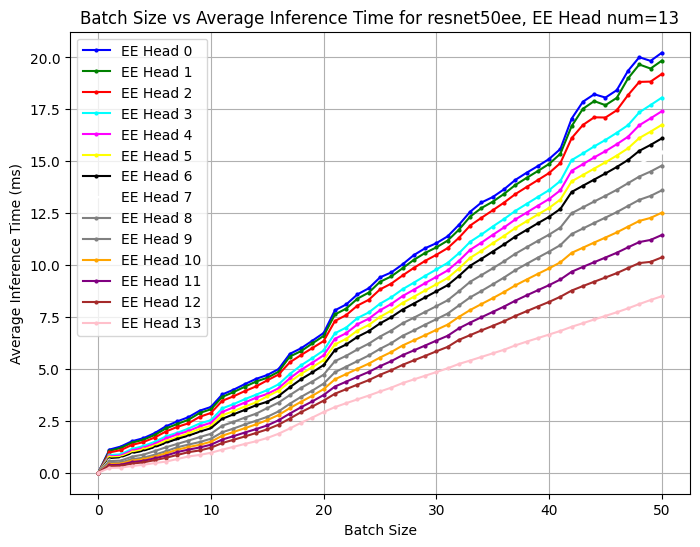

In [2]:
# draw all inference times by plot
batch_list = list(range(batch_nums + 1))
color_list = ['blue', 'green', 'red', 'cyan',
'magenta', 'yellow', 'black', 'white', 'gray', 'grey', 'orange', 'purple', 'brown', 'pink']
plt.figure(figsize=(8,6))

# inference_times_all
for i in range(ee_head_nums+1):
    ee_head_inference_times = inference_times_all[:,i]
    plt.plot(batch_list, ee_head_inference_times, marker='o', markersize=2, color=color_list[i % len(color_list)], label=f'EE Head {i}')
plt.xlabel('Batch Size')
plt.ylabel('Average Inference Time (ms)')
plt.legend()
plt.title(f'Batch Size vs Average Inference Time for {model_name}, EE Head num={ee_head_nums}')
plt.grid(True)

# plt.savefig(f'{model_name}_inference_time_vs_batch_size.png')
plt.show()

In [5]:
# draw efficiency curves
batch_list = list(range(batch_nums + 1))
color_list = ['blue', 'green', 'red', 'cyan',
'magenta', 'yellow', 'black', 'white', 'gray', 'grey', 'orange', 'purple', 'brown', 'pink']
plt.figure(figsize=(8,6))

inference_times_all
for i in range(ee_head_nums+1):
    first_head_time = inference_times_all[1,i] # ignore batch 0
    ee_head_efficiency =  first_head_time* np.asarray(batch_list[1:])/inference_times_all[1:,i]
    plt.plot(batch_list[1:], ee_head_efficiency, marker='o', markersize=2, color=color_list[i % len(color_list)], label=f'EE Head {i}')
plt.xlabel('Batch Size')
plt.ylabel('Inference Efficiency')
plt.legend(    fontsize=8,       # 字体变小
    markerscale=0.8,  # 图例中点/线的缩放
    handlelength=1.0, # 图例线段长度变短
    borderpad=0.3,    # 边框内边距变小
    labelspacing=0.3, # 各行之间间距变小
    )
plt.title(f'Batch Size vs Inference Efficiency for {model_name}, EE Head num={ee_head_nums}')
plt.grid(True)

# plt.savefig(f'{model_name}_inference_time_vs_batch_size.png')
plt.show()

In [3]:
np.set_printoptions(linewidth=120)
print(np.round(inference_times_all, 3))

[[ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 1.114  1.05   0.976  0.85   0.782  0.745  0.679  0.606  0.558  0.475  0.418  0.364  0.322  0.234]
 [ 1.26   1.194  1.089  0.887  0.823  0.765  0.704  0.645  0.583  0.489  0.438  0.383  0.331  0.245]
 [ 1.516  1.448  1.34   1.145  1.069  0.99   0.921  0.843  0.773  0.655  0.585  0.513  0.441  0.324]
 [ 1.661  1.587  1.475  1.281  1.2    1.118  1.037  0.955  0.871  0.722  0.647  0.574  0.499  0.381]
 [ 1.904  1.817  1.693  1.486  1.393  1.308  1.215  1.125  1.039  0.865  0.78   0.69   0.605  0.467]
 [ 2.235  2.131  1.985  1.748  1.649  1.536  1.434  1.323  1.224  1.034  0.93   0.823  0.718  0.534]
 [ 2.469  2.344  2.204  1.919  1.843  1.705  1.629  1.492  1.385  1.225  1.107  0.993  0.855  0.658]
 [ 2.674  2.549  2.379  2.123  2.005  1.896  1.782  1.661  1.547  1.354  1.236  1.112  0.989  0.782]
 [ 2.987  2.878  2.69   2.37   2.232  2.114  1.974  1.851  1.715  1.478  1.344  1.215  1.07

In [9]:
np.set_printoptions(linewidth=120)
print(np.round(max_times_all-min_times_all, 3))

[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.105 0.595 0.114 0.236 0.109 0.11  0.19  0.109 0.137 0.109 0.106 0.113 0.662 0.113]
 [0.209 0.085 0.567 0.13  0.132 0.136 0.146 0.183 0.137 0.133 0.117 0.137 0.137 0.149]
 [0.056 0.088 0.049 0.054 0.075 0.05  0.138 0.052 0.09  0.118 0.087 0.063 0.111 0.085]
 [0.106 0.111 0.093 0.041 0.027 0.026 0.207 0.042 0.044 0.028 0.026 0.029 0.029 0.07 ]
 [0.067 0.071 0.03  0.053 0.026 0.027 0.024 0.045 0.043 0.016 0.015 0.016 0.018 0.084]
 [0.034 0.088 0.038 0.057 0.03  0.077 0.029 0.039 0.045 0.133 0.024 0.21  0.021 0.131]
 [0.053 0.05  0.041 0.033 0.081 0.022 0.022 0.021 0.038 0.02  0.108 0.025 0.038 0.018]
 [0.028 0.053 0.051 0.029 0.029 0.042 0.03  0.035 0.03  0.031 0.022 0.036 0.04  0.022]
 [0.169 0.066 0.047 0.048 0.042 0.06  0.043 0.035 0.042 0.043 0.066 0.063 0.067 0.037]
 [0.045 0.068 0.066 0.051 0.047 0.047 0.044 0.051 0.052 0.044 0.045 0.044 0.044 0.039]
 [0.059 0.067 0.099 0.052 0.053 0.067 0.051

In [7]:
import numpy as np
import matplotlib,json,os
# matplotlib.use('Agg', force=True)
import matplotlib.pyplot as plt
import math

def plot_poisson(lam, k_max=None):
    if k_max is None:
        k_max = int(lam + 5 * lam**0.5)
    ks = np.arange(0, k_max + 1)
    pmf = np.exp(-lam) * np.power(lam, ks) / np.array([math.factorial(k) for k in ks])

    plt.plot(ks, pmf, "o", color="tab:blue", label="PMF")   # 点
    plt.vlines(ks, 0, pmf, colors="tab:blue", alpha=0.2)    # 细线可选
    plt.title(f"Poisson PMF (lambda={lam})")
    plt.xlabel("k")
    plt.ylabel("P(K=k)")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_total_poisson(lam, n_slots, delta_t=1.0):
    lam_tot = lam * delta_t * n_slots
    k_max = int(lam_tot + 5 * math.sqrt(lam_tot))  # 覆盖右尾
    ks = np.arange(0, k_max + 1)
    pmf = np.exp(-lam_tot) * lam_tot**ks / np.array([math.factorial(k) for k in ks])
    
    plt.bar(ks, pmf, color="skyblue", edgecolor="k")
    plt.title(f"Total count in {n_slots} slots, Poisson(lam={lam_tot:.2f})")
    plt.xlabel("total event number K")
    plt.ylabel("P(K=k)")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()
intensity = 4
plot_poisson(intensity)
plot_total_poisson(intensity, 5)


In [8]:
def get_total_poisson(lam, n_slots, delta_t=1.0):
    lam_tot = lam * delta_t * n_slots
    k_max = int(lam_tot + 5 * math.sqrt(lam_tot))  # 覆盖右尾
    ks = np.arange(0, k_max + 1)
    pmf = np.exp(-lam_tot) * lam_tot**ks / np.array([math.factorial(k) for k in ks])
    return pmf
    # plt.bar(ks, pmf, color="skyblue", edgecolor="k")
    # plt.title(f"Total count in {n_slots} slots, Poisson(lam={lam_tot:.2f})")
    # plt.xlabel("total event number K")
    # plt.ylabel("P(K=k)")
    # plt.grid(axis="y", alpha=0.3)
    # plt.tight_layout()
    # plt.show()

intensity = 2
answer = []
for slot in range(1,91):
    n_slot_distribution = get_total_poisson(intensity, slot)
    if len(n_slot_distribution) > 50:
        left_distribution_sum = np.sum(n_slot_distribution[50:])
        if left_distribution_sum > 0.1:
            print(f'Warning: For {slot} slots left distribution sum beyond 50 is {left_distribution_sum:.6f} significant probability mass beyond 50 events!')
            break
        else:
            print(f'For {slot} slots, left distribution sum beyond 50 is {left_distribution_sum:.6f}')
        n_slot_distribution = n_slot_distribution[:50]
    n_slot_est_batch_inference_time = 0.0
    for i, prob in enumerate(n_slot_distribution):
        n_slot_est_batch_inference_time += prob * inference_times_all[i][0]
    if slot > n_slot_est_batch_inference_time:
        answer.append(slot)
    print(f'{slot} slots, estimated batch size: {intensity*slot:.2f} estimated batch inference time: ', n_slot_est_batch_inference_time)
if answer:
    print('Final answer: ', answer)
else:
    print('No valid slot number found')

1 slots, estimated batch size: 2.00 estimated batch inference time:  1.1729570709850745
2 slots, estimated batch size: 4.00 estimated batch inference time:  1.7113301715997051
3 slots, estimated batch size: 6.00 estimated batch inference time:  2.2166835792223245
4 slots, estimated batch size: 8.00 estimated batch inference time:  2.7594058536320043
5 slots, estimated batch size: 10.00 estimated batch inference time:  3.3422716590663746
6 slots, estimated batch size: 12.00 estimated batch inference time:  3.9630204102747255
7 slots, estimated batch size: 14.00 estimated batch inference time:  4.634970460240015
8 slots, estimated batch size: 16.00 estimated batch inference time:  5.376597818625582
9 slots, estimated batch size: 18.00 estimated batch inference time:  6.187125606089939
10 slots, estimated batch size: 20.00 estimated batch inference time:  7.042459279391524
11 slots, estimated batch size: 22.00 estimated batch inference time:  7.909827496858522
12 slots, estimated batch si

In [9]:
import numpy as np

def generate_traffic(intensity, duration):
    # note: here intensity is in ms, and duration is also ms unit
    # first step: generate arrival time first
    arrival_times, t = [], 0
    while t < duration:
        # Generate the time until the next arrival using an exponential distribution
        inter_arrival_time = np.random.exponential(1 / intensity)
        t += inter_arrival_time
        if t < duration:
            arrival_times.append(t)

    # second step: construct traffic in the time domain 
    traffic = np.zeros(int(duration))
    indexs = np.asarray(arrival_times, dtype=int) # indexs could have multiple at the same position
    uniques, counts = np.unique(indexs, return_counts=True)
    traffic[uniques] = counts # assign counts to the position, not 1
    return np.array(traffic, dtype=int)

traffic = generate_traffic(intensity=1, duration=30000)

print(f'estimate lambda from generated traffic: {traffic[-1000:].mean()}')


estimate lambda from generated traffic: 1.017


In [26]:
import os,json,pickle
import numpy as np
import matplotlib,json,os
# matplotlib.use('Agg', force=True)
import matplotlib.pyplot as plt

all_results = pickle.load(open('./single_model_result/results_intensity_3.0.pkl', 'rb'))

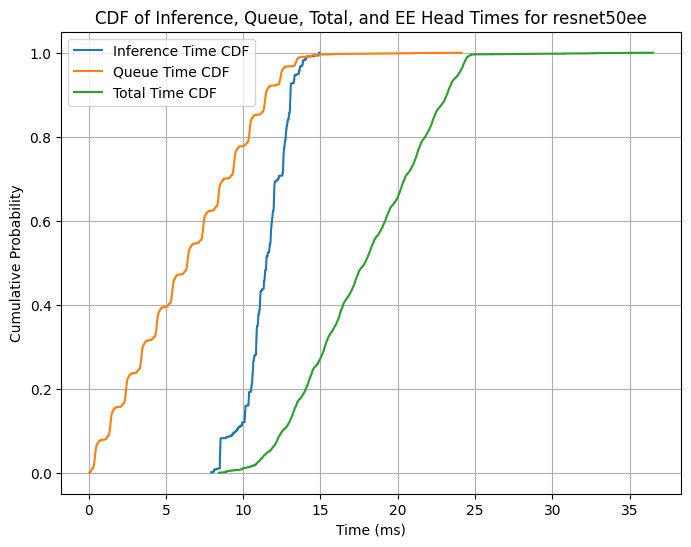

In [29]:

tasks = all_results['resnet50ee']
infer_times = []
queue_times = []
total_times = []
ee_head = []
for task in tasks.values():
    infer_times.append(task.infer_time)
    queue_times.append(task.queue_time)
    total_times.append(task.total_time)
    ee_head.append(task.ee_head)
    # print(f'id: {task.tk_id}, infer_time: {task.infer_time}, queue_time: {task.queue_time}, toal_time: {task.total_time}')
# draw all cdf
plt.figure(figsize=(8,6))
sorted_infer_times = np.sort(infer_times)
sorted_queue_times = np.sort(queue_times)
sorted_total_times = np.sort(total_times)
sorted_ee_head = np.sort(ee_head)
cdf_infer = np.arange(1, len(sorted_infer_times)+1) / len(sorted_infer_times)
cdf_queue = np.arange(1, len(sorted_queue_times)+1) / len(sorted_queue_times)
cdf_total = np.arange(1, len(sorted_total_times)+1) / len(sorted_total_times)
cdf_ee_head = np.arange(1, len(sorted_ee_head)+1) / len(sorted_ee_head)
plt.plot(sorted_infer_times, cdf_infer, label='Inference Time CDF')
plt.plot(sorted_queue_times, cdf_queue, label='Queue Time CDF')
plt.plot(sorted_total_times, cdf_total, label='Total Time CDF')
# plt.plot(sorted_ee_head, cdf_ee_head, label='EE Head Time CDF')
plt.xlabel('Time (ms)')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Inference, Queue, Total, and EE Head Times for resnet50ee')
plt.legend()
plt.grid(True)
# plt.savefig('resnet50ee_time_cdf.png')
plt.show()